In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time

from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore")


In [2]:
df= pd.read_csv('Data/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Describing data:

# Bank client data:
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# Related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# Other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# Social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

We don't have any null values. Let's take a look at our data using histograms for categorical data.

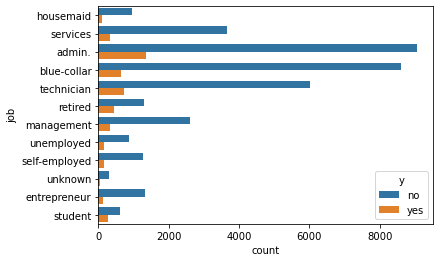

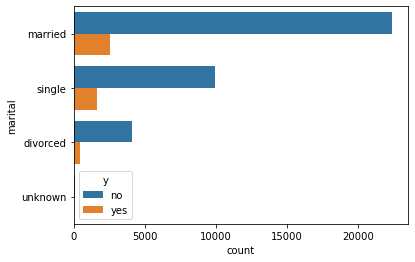

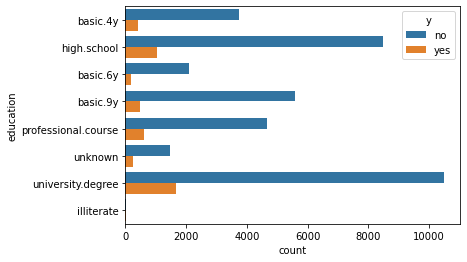

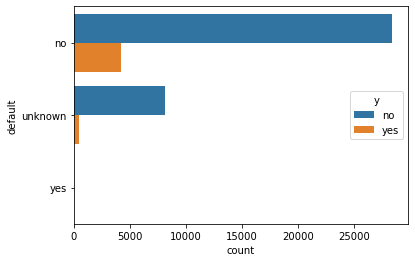

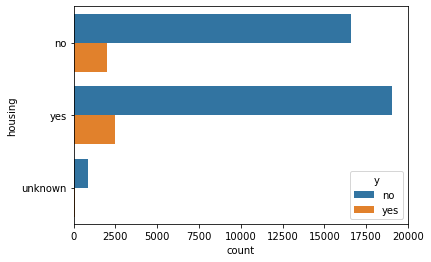

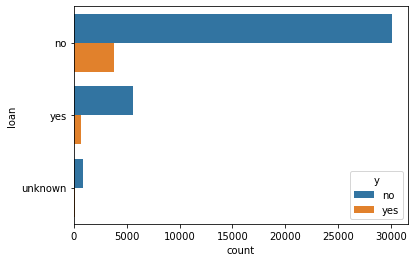

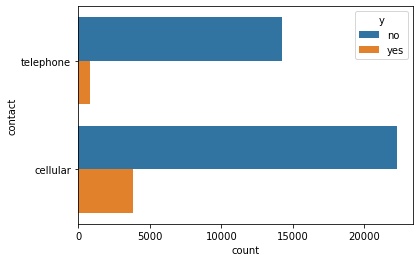

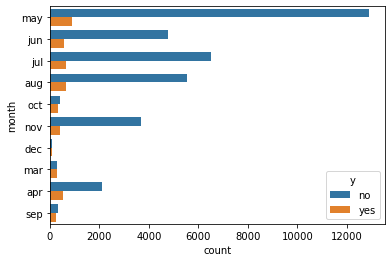

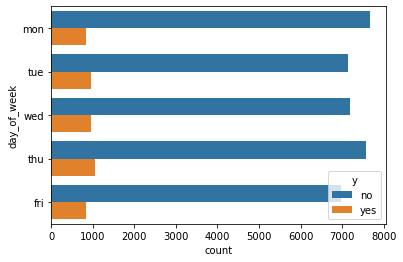

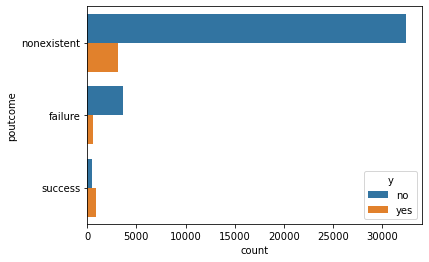

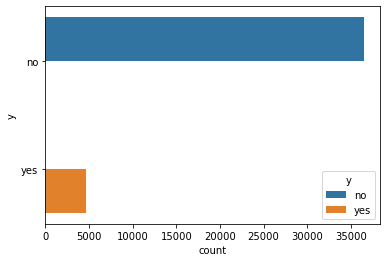

In [4]:
for col in df.select_dtypes(include='object').columns:
    plt.figure()
    sns.countplot(data=df, y=col, hue='y')

We are trying to find the response rates. We're trying to find best model for predictions. 

Also, turns out there are null values they're just filled in as 'unkown'. Job, marital, education, default, housing and loan have unkown values.

The goal os this model is to explain the success of a contact, if the client subscribes the deposit.A model can increase campaign efficiency by identifying the main characteristics that affect success. 

### Numeric Data

In [6]:
num_col=['age']
df['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

The mean is greater than the median value which means age is skewed to the right. Create a histogram to assess outliers


<AxesSubplot:xlabel='age', ylabel='Count'>

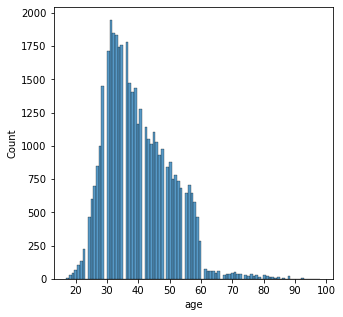

In [7]:
plt.figure(figsize=(5,5))
sns.histplot(df['age'])

zscore tells us how much a value differs from the standard deviation and can help us with dropping outliers.

In [11]:
outlier_zscore = {}

for col, _ in outlier_zscore.items():
    zscore = np.abs(stats.zscore(df[col]))
    df.drop(df[np.abs(stats.zscore(df[col]))>4.5].index, inplace=True)    

### Categorical Data
Leave unknown as a category

In [19]:
X = df.iloc[:, 0:7]
y = df['y'].map({'no': 0, 'yes': 1})
X, y

(       age          job  marital            education  default housing loan
 0       56    housemaid  married             basic.4y       no      no   no
 1       57     services  married          high.school  unknown      no   no
 2       37     services  married          high.school       no     yes   no
 3       40       admin.  married             basic.6y       no      no   no
 4       56     services  married          high.school       no      no  yes
 ...    ...          ...      ...                  ...      ...     ...  ...
 41183   73      retired  married  professional.course       no     yes   no
 41184   46  blue-collar  married  professional.course       no      no   no
 41185   56      retired  married    university.degree       no     yes   no
 41186   44   technician  married  professional.course       no      no   no
 41187   74      retired  married  professional.course       no     yes   no
 
 [41188 rows x 7 columns],
 0        0
 1        0
 2        0
 3        0

### Logistic Regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)


In [21]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
lgr_pipe = Pipeline([('transformer', transformer),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

In [22]:
t0 = time.time()
lgr_pipe.fit(X_train, y_train)
print(time.time() - t0)

0.4525108337402344


### Logistic Regression

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9137
           1       0.00      0.00      0.00      1160

    accuracy                           0.89     10297
   macro avg       0.44      0.50      0.47     10297
weighted avg       0.79      0.89      0.83     10297



C:\Users\mohar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mohar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mohar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


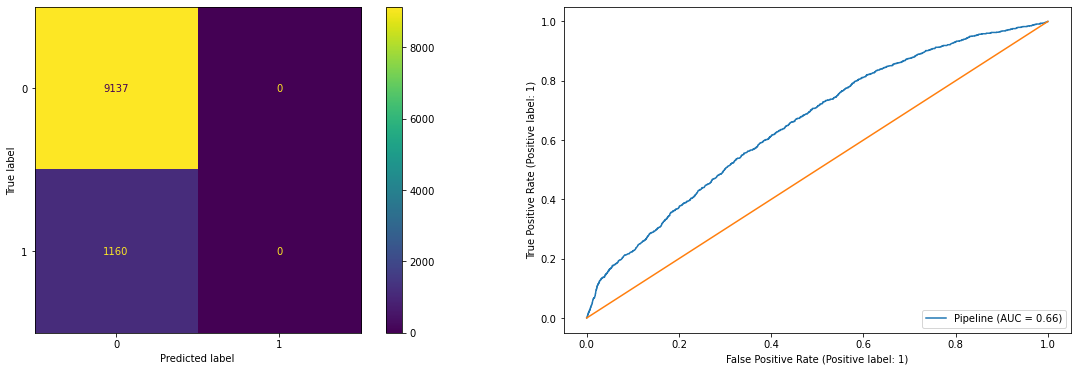

In [30]:
log_predict_train = lgr_pipe.predict(X_train)
log_predict_test = lgr_pipe.predict(X_test)
log_report = classification_report(y_test, log_predict_test)
print(log_report)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### Compare Models

In [31]:
knn_pipe = Pipeline([('transformer', transformer),
                    ('knn', KNeighborsClassifier())])
tree_pipe = Pipeline([('transformer', transformer),
                    ('tree', DecisionTreeClassifier())])
svm_pipe = Pipeline([('transformer', transformer),
                    ('svm', svm.SVC())])

### Decision Tree

0.6233632564544678
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      9137
           1       0.24      0.09      0.13      1160

    accuracy                           0.87     10297
   macro avg       0.57      0.53      0.53     10297
weighted avg       0.82      0.87      0.84     10297



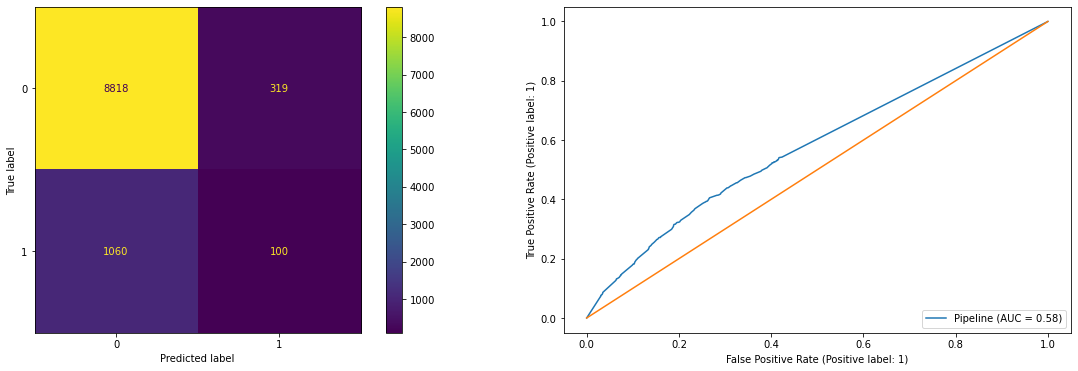

In [38]:
from time import time
t1 = time()
tree_pipe.fit(X_train, y_train)
print(time() - t1)

tree_train = tree_pipe.predict(X_train)
tree_test = tree_pipe.predict(X_test)
tree = classification_report(y_test, tree_test)
print(tree)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(tree_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(tree_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### SVM 

75.38069939613342
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9137
           1       0.44      0.01      0.03      1160

    accuracy                           0.89     10297
   macro avg       0.66      0.51      0.48     10297
weighted avg       0.84      0.89      0.84     10297



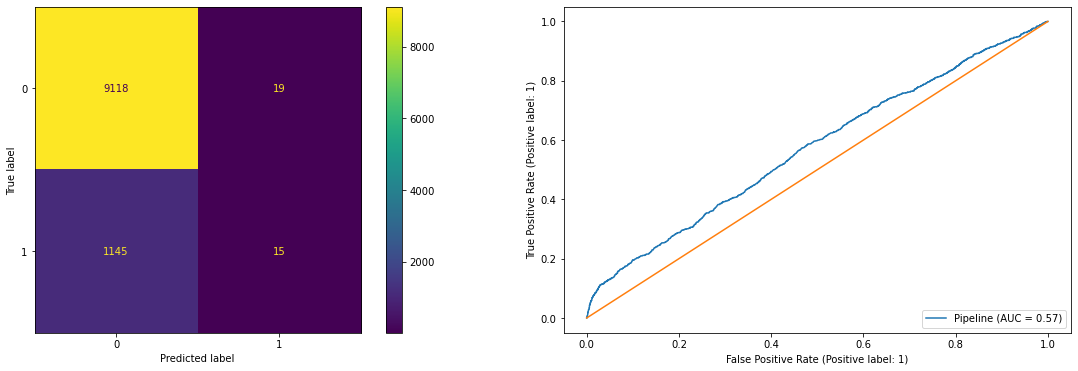

In [43]:
from time import time
t2 = time()
svm_pipe.fit(X_train, y_train)
print(time() - t2)

svm_train = svm_pipe.predict(X_train)
svm_test = svm_pipe.predict(X_test)
svm_report = classification_report(y_test, svm_test)
print(svm_report)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(svm_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(svm_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### KNN 

0.09275341033935547
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9137
           1       0.33      0.08      0.13      1160

    accuracy                           0.88     10297
   macro avg       0.61      0.53      0.53     10297
weighted avg       0.83      0.88      0.84     10297



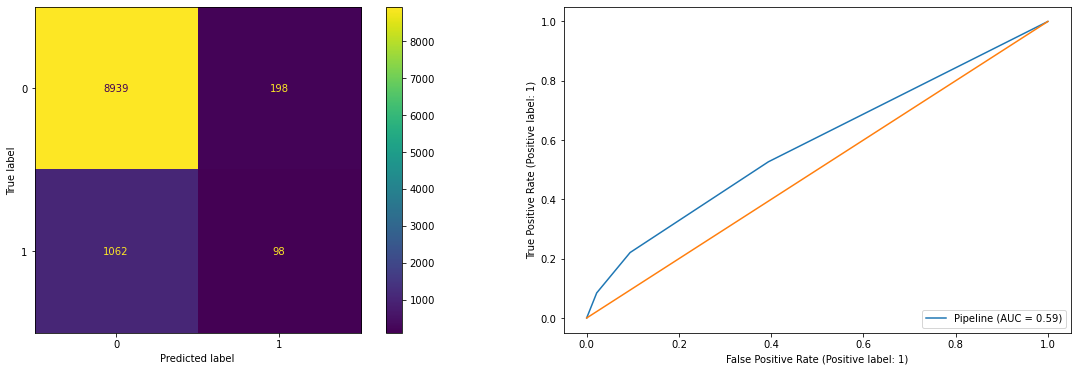

In [45]:
from time import time
t3 = time()
knn_pipe.fit(X_train, y_train)
print(time() - t3)

knn_train = knn_pipe.predict(X_train)
knn_test = knn_pipe.predict(X_test)
knn_report = classification_report(y_test, knn_test)
print(knn_report)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

In [46]:
res_dict = {'model': ['Decision Tree','KNN', 'Logistic Regression', 'SVM'],
           'train score': [tree_pipe.score(X_train, y_train), knn_pipe.score(X_train, y_train), lgr_pipe.score(X_train, y_train), svm_pipe.score(X_train, y_train)],
           'test score': [tree_pipe.score(X_test, y_test), knn_pipe.score(X_test, y_test), lgr_pipe.score(X_test, y_test), svm_pipe.score(X_test, y_test)],
           'train time': [0.527, 0.072, 0.262, 0.245]}
results_df = pd.DataFrame(res_dict).set_index('model')
results_df

,train score,test score,train time
model,,,
Decision Tree,0.917775,0.866077,0.527
KNN,0.890680,0.877634,0.072
Logistic Regression,0.887346,0.887346,0.262
SVM,0.888317,0.886957,0.245


### Improving the Model
Now that we have some basic models on the board, we want to try to improve these. Below, we list a few things to explore in this pursuit.

More feature engineering and exploration. For example, should we keep the gender feature? Why or why not?
Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.
Adjust your performance metric

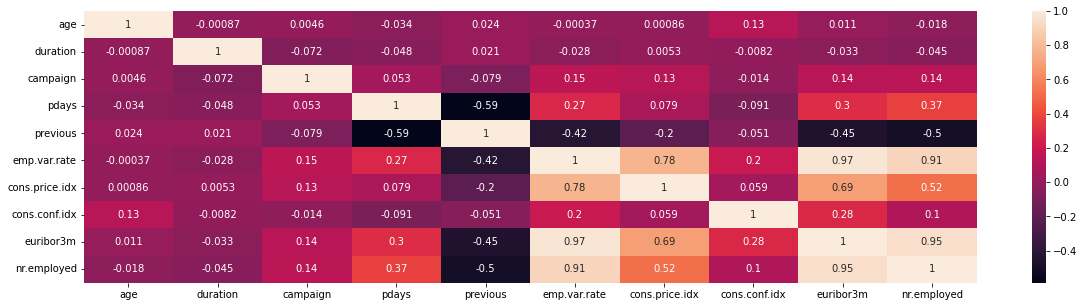

In [48]:
# heatmap plot of the correlations of the numeric features
plt.figure(figsize=(20, 5))
sns.heatmap(df.corr(), annot=True);

In [49]:
# remove non-relevant columns (see original histograms for assessment)
df.drop(columns=['marital', 'housing', 'loan', 'day_of_week'], inplace=True)

0.1531352996826172
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9137
           1       0.33      0.08      0.13      1160

    accuracy                           0.88     10297
   macro avg       0.61      0.53      0.53     10297
weighted avg       0.83      0.88      0.84     10297



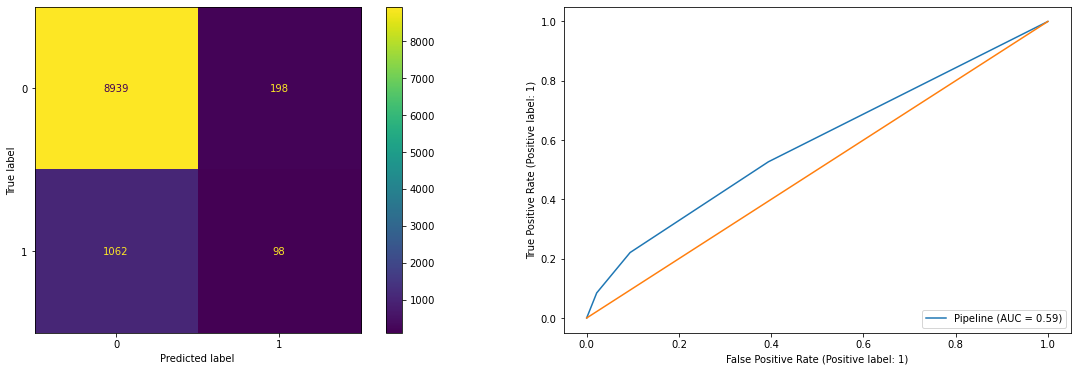

In [57]:
from time import time
t4 = time()
knn_pipe.fit(X_train, y_train)
print(time() - t4)

knn_train = knn_pipe.predict(X_train)
knn_test = knn_pipe.predict(X_test)
knn_report = classification_report(y_test, knn_test)
print(knn_report)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

128.08756852149963
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9137
           1       0.44      0.01      0.03      1160

    accuracy                           0.89     10297
   macro avg       0.66      0.51      0.48     10297
weighted avg       0.84      0.89      0.84     10297



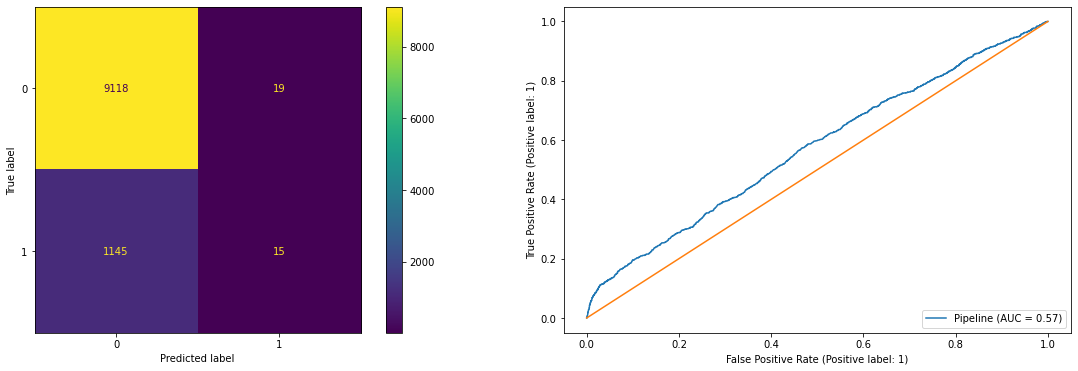

In [58]:
from time import time
t5 = time()
svm_pipe.fit(X_train, y_train)
print(time() - t5)

svm_train = svm_pipe.predict(X_train)
svm_test = svm_pipe.predict(X_test)
svm_report = classification_report(y_test, svm_test)
print(svm_report)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(svm_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(svm_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

0.969437837600708
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      9137
           1       0.24      0.09      0.13      1160

    accuracy                           0.87     10297
   macro avg       0.57      0.53      0.53     10297
weighted avg       0.82      0.87      0.84     10297



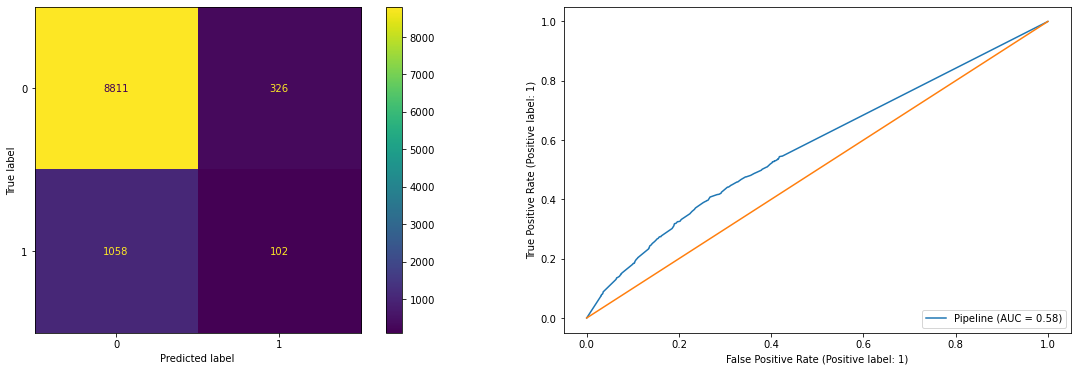

In [59]:
from time import time
t6 = time()
tree_pipe.fit(X_train, y_train)
print(time() - t6)

tree_train = tree_pipe.predict(X_train)
tree_test = tree_pipe.predict(X_test)
tree = classification_report(y_test, tree_test)
print(tree)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(tree_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(tree_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

In [67]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
extractor = SelectFromModel(LogisticRegression(solver = 'liblinear',random_state = 42))

In [76]:
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression())])
lgr_params = {'lgr__penalty': ['l1', 'l2'],
              'lgr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'lgr__class_weight': ['none', 'balanced'],
              'lgr__solver': ['liblinear']}
lgr_grid = GridSearchCV(lgr_pipe, param_grid=lgr_params, verbose = 1, cv = 3, n_jobs=-1, scoring = 'roc_auc')

lgr_fit= lgr_grid.fit(X_train, y_train)

print('Top Penalty:', lgr_grid.best_estimator_.get_params()['lgr__penalty'])
print('Top C:', lgr_grid.best_estimator_.get_params()['lgr__C'])
print('Top Class Weighting:', lgr_grid.best_estimator_.get_params()['lgr__class_weight'])
print('Top Solver:', lgr_grid.best_estimator_.get_params()['lgr__solver'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Top Penalty: l2
Top C: 0.001
Top Class Weighting: balanced
Top Solver: liblinear


In [77]:
svm_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('svm', svm.SVC())])

svm_params = {'svm__C':[0.1,1,1000],
              'svm__kernel':['rbf','sigmoid','linear'],
              'svm__degree':[2,4,6],
              'svm__gamma': [1, 0.01, 0.0001]}
svm_grid = GridSearchCV(svm_pipe, param_grid=svm_params, verbose = 1, cv = 3, n_jobs=-1, scoring = 'roc_auc')

svm_grid.fit(X_train, y_train)
print('Top C:', svm_grid.best_estimator_.get_params()['svm__C'])
print('Top Kernel:', svm_grid.best_estimator_.get_params()['svm__kernel'])
print('Top Degree:', svm_grid.best_estimator_.get_params()['svm__degree'])
print('Top Gamma:', svm_grid.best_estimator_.get_params()['svm__gamma'])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Top C: 0.1
Top Kernel: sigmoid
Top Degree: 2
Top Gamma: 0.0001


In [78]:
tree_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('tree', DecisionTreeClassifier())])

tree_params = {"tree__criterion":['gini', 'entropy'],
               "tree__max_depth":range(1,10),
               "tree__min_samples_split":range(1,10),
               "tree__min_samples_leaf":range(1,5)}

tree_grid = GridSearchCV(tree_pipe, param_grid=tree_params, verbose = 1, cv = 3, n_jobs=-1, scoring = 'roc_auc')

tree_grid.fit(X_train, y_train)
print('Top Tree Criterion:', tree_grid.best_estimator_.get_params()['tree__criterion'])
print('Top Max Depth:', tree_grid.best_estimator_.get_params()['tree__max_depth'])
print('Top Min Samples Split:', tree_grid.best_estimator_.get_params()['tree__min_samples_split'])
print('Top Min Samples Leaf:', tree_grid.best_estimator_.get_params()['tree__min_samples_leaf'])

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Top Tree Criterion: gini
Top Max Depth: 9
Top Min Samples Split: 2
Top Min Samples Leaf: 2


In [79]:
knn_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': (1,10, 1),
              'knn__leaf_size': (20,40,1),
              'knn__p': (1,2),
              'knn__weights': ('uniform', 'distance'),
              'knn__metric': ('minkowski', 'chebyshev')}
knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params, verbose = 1, cv = 3, n_jobs=-1, scoring = 'roc_auc')

knn_grid.fit(X_train, y_train)
print('Top n Neighbors:', knn_grid.best_estimator_.get_params()['knn__n_neighbors'])
print('Top Leaf size:', knn_grid.best_estimator_.get_params()['knn__leaf_size'])
print('Top P:', knn_grid.best_estimator_.get_params()['knn__p'])
print('Top Weights:', knn_grid.best_estimator_.get_params()['knn__weights'])
print('Metric:', knn_grid.best_estimator_.get_params()['knn__metric'])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Top n Neighbors: 10
Top Leaf size: 20
Top P: 1
Top Weights: distance
Metric: minkowski
